In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

import sys
sys.path.append('C:/Users/acomi/DESU_OFF/scripts')


In [2]:
path= "C:/Users/acomi/Downloads/data_DESU_2.csv"
df = pd.read_csv(path, delimiter=';', decimal = ",", encoding="utf-8", na_values=["", " "], na_filter=True)
df.head()

,mouse,vol(fv),perfctx,perfthal,Ace,Ala,Asp,bGlu,GABA,Gly,...,Lac,Myo,Scy,Suc,Tau,tCo,tNa,Glx,tCr,behav
0,C1-2R,0.058380,44.14,69.0910,1.734060e-17,7.599709e-02,8.982798e-02,0.101835,0.080081,0.123462,...,0.071801,2.445724e-01,1.497486e-02,0.016576,0.177655,0.079899,0.095911,0.360444,0.414571,9.56
1,C1-4V,0.054904,119.74,173.4525,2.864256e-02,2.074650e-17,2.074650e-17,0.149997,0.199037,0.072974,...,0.083009,1.058961e-01,1.032199e-02,0.031450,0.127429,0.073409,0.103809,0.251717,0.245582,11.96
2,C3-1N,0.054323,117.88,110.9430,2.053260e-17,2.485268e-02,2.053260e-17,0.030867,0.108392,0.174835,...,0.057157,1.831715e-01,2.431678e-02,0.027117,0.199119,0.043085,0.098994,0.300538,0.301312,4.32
3,C3-3N,0.057803,49.63,65.0625,3.084990e-17,1.393090e-02,5.419405e-02,0.262064,0.072793,0.150699,...,0.133484,3.325312e-01,3.084990e-17,0.017590,0.463181,0.112738,0.401151,0.443224,0.741725,196.04
4,C3-4N,0.052949,NaN,NaN,1.288696e-02,5.345350e-02,1.113894e-01,0.145943,0.006817,0.161985,...,0.117177,2.658580e-17,2.981603e-02,0.103459,0.270617,0.080647,0.248493,0.514835,0.572566,129.68


In [3]:
df = df.drop(['mouse'], axis = 1)

In [4]:
#check the data for missing values
percent_missing=df.isnull().sum()*100/len(df)
print(percent_missing)
percent_missing.sort_values(ascending=False,inplace=True)

vol(fv)      0.000000
perfctx      8.163265
perfthal     8.163265
Ace         24.489796
Ala         24.489796
Asp         24.489796
bGlu        24.489796
GABA        24.489796
Gly         24.489796
Gsh         24.489796
Lac         24.489796
Myo         24.489796
Scy         24.489796
Suc         24.489796
Tau         24.489796
tCo         24.489796
tNa         24.489796
Glx         24.489796
tCr         24.489796
behav        0.000000
dtype: float64


## Exploring the dataset

### Distribution of the data (normality)

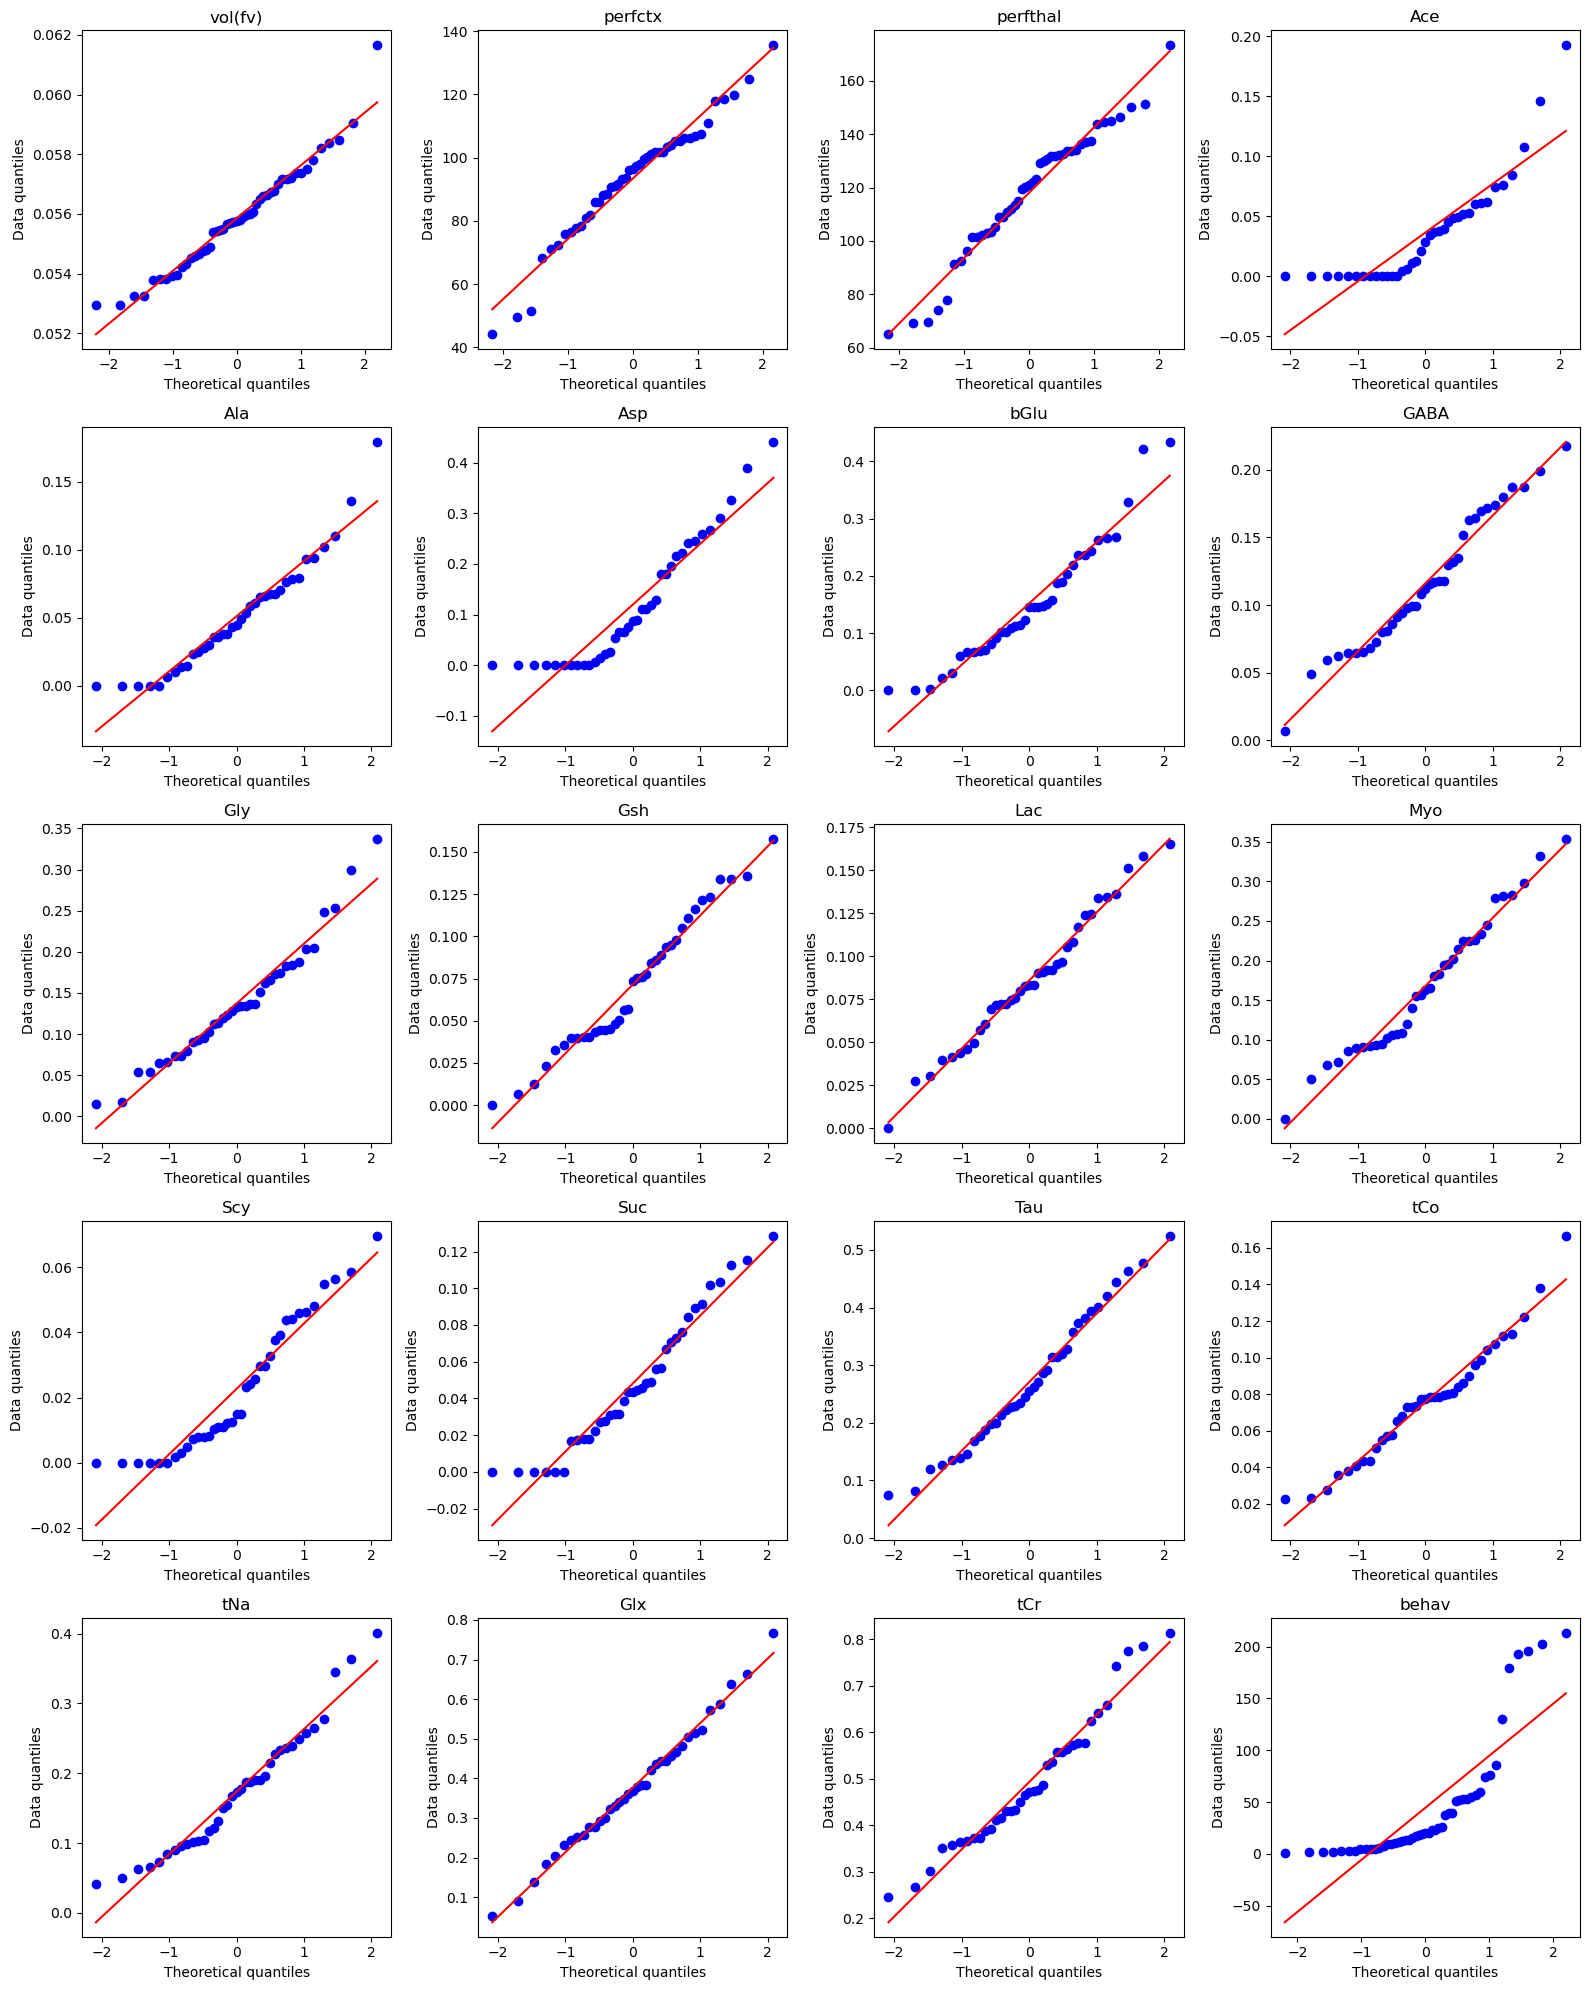

In [5]:
#Q-Q plots for all variables to check the distribution of the data
num_cols = df.select_dtypes(include=["number"]).columns
n_rows, n_cols = 5, 4 #grid size

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
axes = axes.flatten()  
for i, col in enumerate(num_cols):
    data = df[col].dropna()  # ignore NaNs
    stats.probplot(data, dist="norm", plot=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Theoretical quantiles')
    axes[i].set_ylabel('Data quantiles')

plt.tight_layout()
plt.show()

### Visualization of the data and outliers

    Variable  Num_Outliers
0      behav             6
1        Ace             2
2    perfctx             1
3    vol(fv)             1
4        Glx             1
5        Ala             1
6        tCo             1
7        Gly             1
8   perfthal             0
9       GABA             0
10      bGlu             0
11       Asp             0
12       Myo             0
13       Lac             0
14       Gsh             0
15       Scy             0
16       Tau             0
17       Suc             0
18       tNa             0
19       tCr             0


C:\Users\acomi\AppData\Local\Temp\ipykernel_14312\1138343947.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Variable", y="Value", data=df_long, palette="Set2")


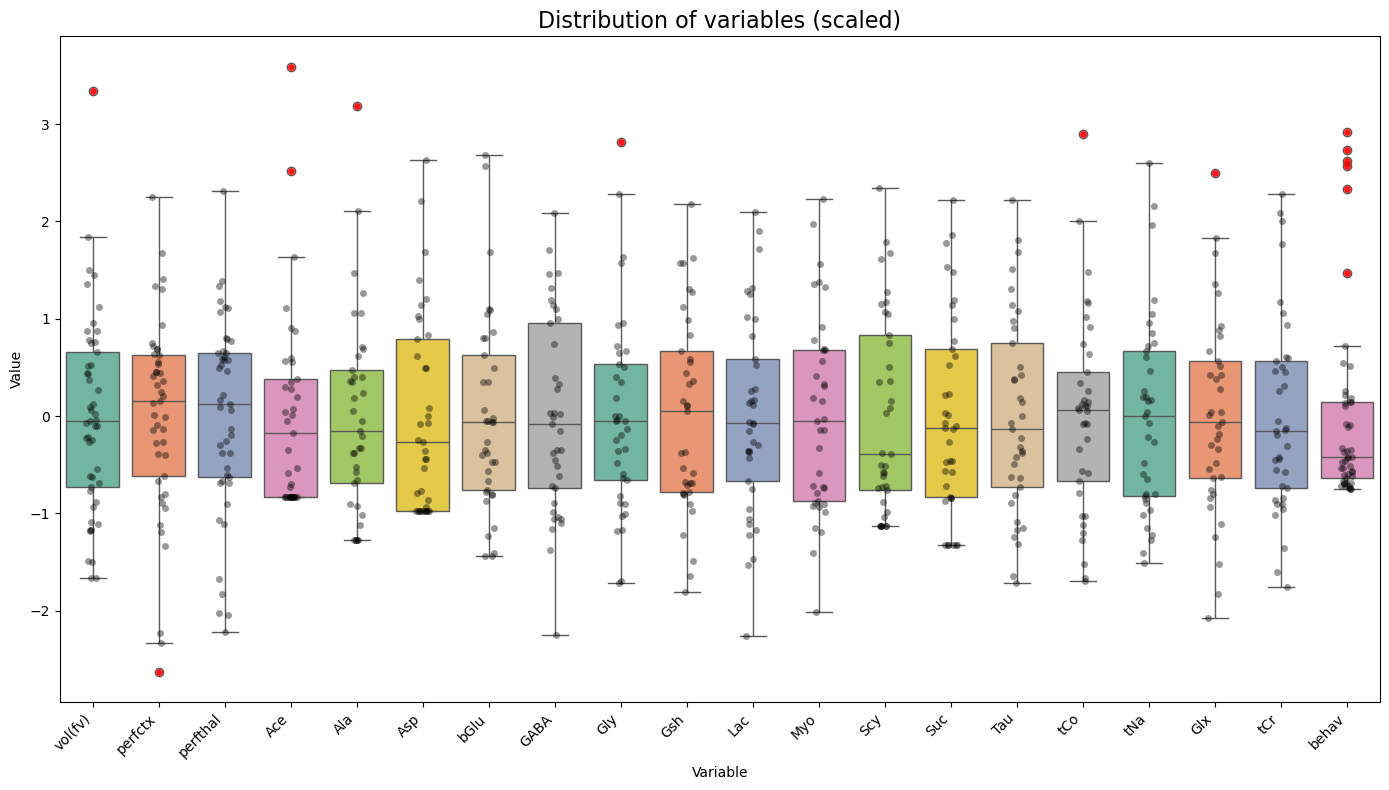

In [6]:
from sklearn.preprocessing import StandardScaler

# Scaling of variables for visualization purposes
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols, index=df.index)

# Detection of outliers using IQR

outliers = pd.DataFrame(False, index=df_scaled.index, columns=df_scaled.columns)

for col in df_scaled.columns:
    Q1 = df_scaled[col].quantile(0.25)
    Q3 = df_scaled[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = (df_scaled[col] < lower_bound) | (df_scaled[col] > upper_bound)

outlier_counts = outliers.sum().sort_values(ascending=False)
outlier_table = pd.DataFrame({"Variable": outlier_counts.index,"Num_Outliers": outlier_counts.values})
print(outlier_table)

# Reshape for plotting and boxplot with all points
df_long = df_scaled.melt(var_name="Variable", value_name="Value")
df_long["Outlier"] = outliers.melt(var_name="Variable", value_name="Outlier")["Outlier"]

plt.figure(figsize=(14, 8))
sns.boxplot(x="Variable", y="Value", data=df_long, palette="Set2")
sns.stripplot(x="Variable", y="Value", data=df_long[~df_long["Outlier"]],color="black", size=5, jitter=True, alpha=0.4) #all data points that are not outliers
sns.stripplot(x="Variable", y="Value", data=df_long[df_long["Outlier"]],color="red", size=5, jitter=False, alpha=0.9, marker="o") #outliers

plt.title("Distribution of variables (scaled)", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [7]:
#We remove outliers in the selected columns

cols_to_clean = ["vol(fv)", "perfctx", "Ace", "Ala", "bGlu", "Gly", "Tau", "tCo", "Glx"]

work_df = df.copy()

for col in cols_to_clean:
    Q1 = work_df[col].quantile(0.25)
    Q3 = work_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace outliers with NaN 
    work_df.loc[(work_df[col] < lower_bound) | (work_df[col] > upper_bound), col] = np.nan


### Correlation matrix

Top correlations with behavior:
             behav
tNa       0.429376
tCo       0.356757
tCr       0.318772
perfctx  -0.188244
Ala      -0.050969
perfthal -0.014098


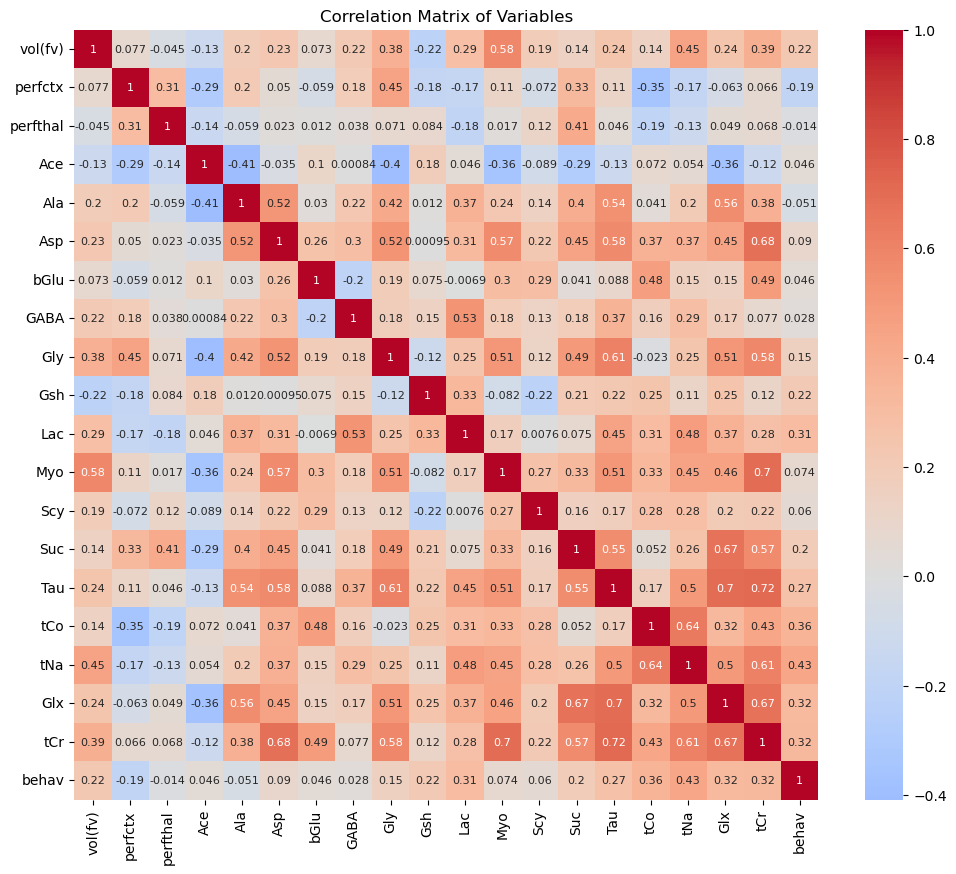

In [8]:
#Correlation matrix and coefficients between behavior and the other variables
corr_matrix_spearman = work_df.corr(method='spearman')
corr_with_behav_spearman = corr_matrix_spearman["behav"].drop("behav")

# Selection of the two strongest highest correlations and the two strongest lowest
top_positive = corr_with_behav_spearman.sort_values(ascending=False).head(3)
top_negative = corr_with_behav_spearman.sort_values().head(3)

top_corr = pd.concat([top_positive, top_negative])
top_corr_df = top_corr.to_frame()
print("Top correlations with behavior:")
print(top_corr_df)

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_spearman, annot=True, annot_kws={"size": 8}, cmap="coolwarm", center=0)
plt.title("Correlation Matrix of Variables")
plt.show()

### ML Pipeline

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
from collections import Counter
from pls_fselector import PLSFeatureSelector 
from learning_curve import plot_learning_curve
from shap_regr import plot_shap_summary

X = work_df.drop(columns=["behav"]).values
y = work_df["behav"].values
feature_names = work_df.drop(columns=["behav"]).columns

loo = LeaveOneOut()


c:\Users\acomi\anaconda3\envs\formation\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Lasso regression

Best alpha Lasso: 12.742749857031322
LOO-CV Lasso+PLS: MSE=3383.768, R²=-0.011

Feature selection stability aka each feature was chosen:
vol(fv): 49/49 times
tNa: 49/49 times
GABA: 47/49 times
Asp: 41/49 times
perfthal: 5/49 times
Ala: 4/49 times
Myo: 1/49 times


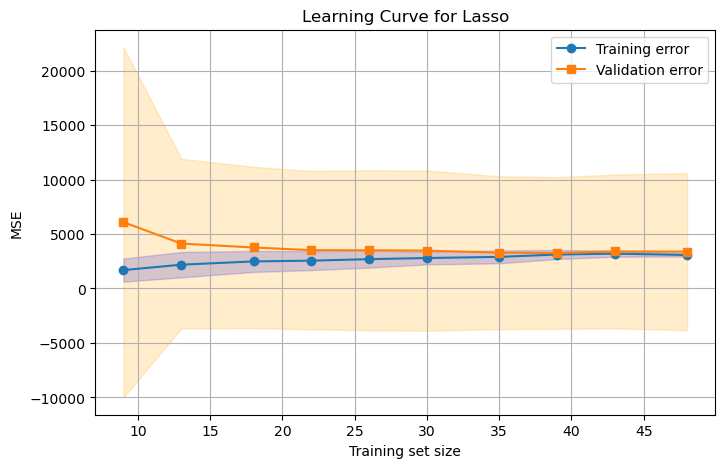

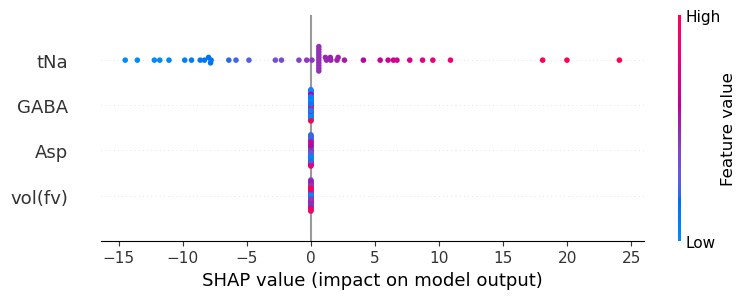

In [15]:

from sklearn.linear_model import Lasso

# Pipeline: Imputer + Scaler + PLS selection + Model

pipe = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=6, feature_names=feature_names)),
    ("lasso", Lasso(max_iter=10000))
])

# Hyperparameter gridsearch
param_grid = {"lasso__alpha": np.logspace(-3, 3, 20)}
grid = GridSearchCV(pipe, param_grid, cv=loo, scoring="neg_mean_squared_error")
grid.fit(X, y)
best_alpha = grid.best_params_["lasso__alpha"]
print("Best alpha Lasso:", best_alpha)

# Evaluate with LOO-CV (and chosen hyperparameters) and track selected features

pipe_best = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=4, feature_names=feature_names)),
    ("lasso", Lasso(alpha=best_alpha, max_iter=10000))
])

y_pred = np.zeros_like(y, dtype=float)
selected_features_all = []

for train_idx, test_idx in loo.split(X):
    pipe_best.fit(X[train_idx], y[train_idx])
    y_pred[test_idx] = pipe_best.predict(X[test_idx])
    selected_features_all.extend(pipe_best.named_steps["pls_select"].get_feature_names())

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"LOO-CV Lasso+PLS: MSE={mse:.3f}, R²={r2:.3f}")

#Feature stability to ensure the used ones are almost always the same
feature_counts = Counter(selected_features_all)
print("\nFeature selection stability aka each feature was chosen:")
for feat, count in feature_counts.most_common():
    print(f"{feat}: {count}/{len(y)} times")

#Plotting of the learning curve
plot_learning_curve(pipe_best, X, y, cv=loo, scoring="neg_mean_squared_error", title="Learning Curve for Lasso")

#Shap to visually explain the model
plot_shap_summary(pipe_best, X, y, feature_step="pls_select", model_step="lasso")

#### Ridge regression

Best alpha Ridge: 112.88378916846884
LOO-CV Ridge+PLS: MSE=3339.444, R²=0.002

Feature selection stability aka each feature was chosen:
vol(fv): 49/49 times
tNa: 49/49 times
GABA: 47/49 times
Asp: 41/49 times
perfthal: 5/49 times
Ala: 4/49 times
Myo: 1/49 times


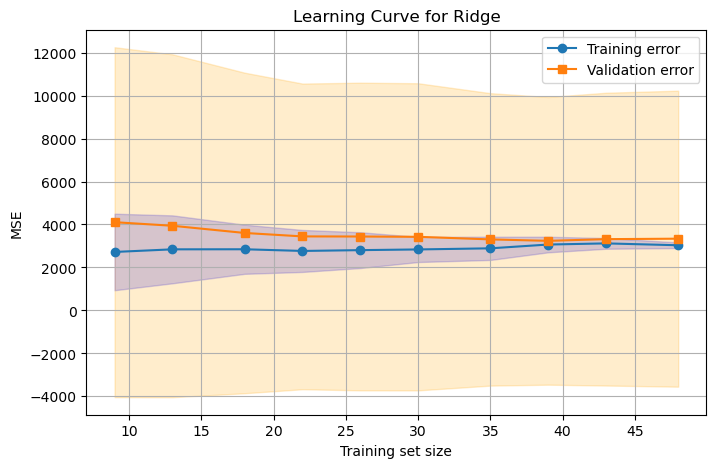

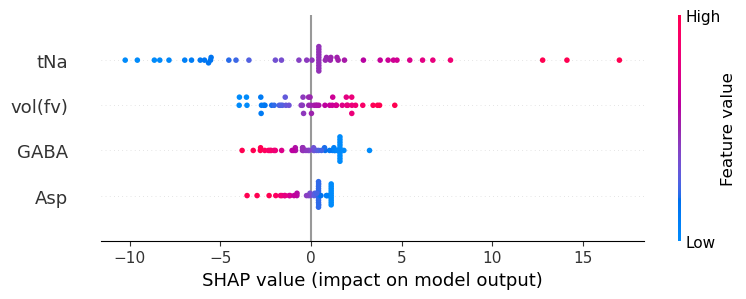

In [16]:
from sklearn.linear_model import Ridge

# Pipeline: Imputer + Scaler + PLS selection + Model

pipe = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=6, feature_names=feature_names)),
    ("ridge", Ridge())
])

# Hyperparameter gridsearch
param_grid = {"ridge__alpha": np.logspace(-3, 3, 20)}
grid = GridSearchCV(pipe, param_grid, cv=loo, scoring="neg_mean_squared_error")
grid.fit(X, y)
best_alpha = grid.best_params_["ridge__alpha"]
print("Best alpha Ridge:", best_alpha)

# Evaluate with LOO-CV and track selected features

pipe_best = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=4, feature_names=feature_names)),
    ("ridge", Ridge(alpha=best_alpha))
])

y_pred = np.zeros_like(y, dtype=float)
selected_features_all = []

for train_idx, test_idx in loo.split(X):
    pipe_best.fit(X[train_idx], y[train_idx])
    y_pred[test_idx] = pipe_best.predict(X[test_idx])
    selected_features_all.extend(pipe_best.named_steps["pls_select"].get_feature_names())

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"LOO-CV Ridge+PLS: MSE={mse:.3f}, R²={r2:.3f}")

#Feature stability to ensure the used ones are almost always the same
feature_counts = Counter(selected_features_all)
print("\nFeature selection stability aka each feature was chosen:")
for feat, count in feature_counts.most_common():
    print(f"{feat}: {count}/{len(y)} times")

#Plotting of the learning curve
plot_learning_curve(pipe_best, X, y, cv=loo, scoring="neg_mean_squared_error", title="Learning Curve for Ridge")

#Shap to visually explain the model
plot_shap_summary(pipe_best, X, y, feature_step="pls_select", model_step="ridge")

#### Elastic Net

Best alpha: 10.0
Best l1_ratio: 1.0
LOO-CV ElasticNet+PLS: MSE=3324.751, R²=0.006

Feature selection stability aka each feature was chosen:
vol(fv): 49/49 times
GABA: 49/49 times
tNa: 49/49 times
Asp: 46/49 times
Ala: 33/49 times
tCr: 24/49 times
Lac: 20/49 times
perfthal: 18/49 times
tCo: 3/49 times
perfctx: 1/49 times
Myo: 1/49 times
Gsh: 1/49 times


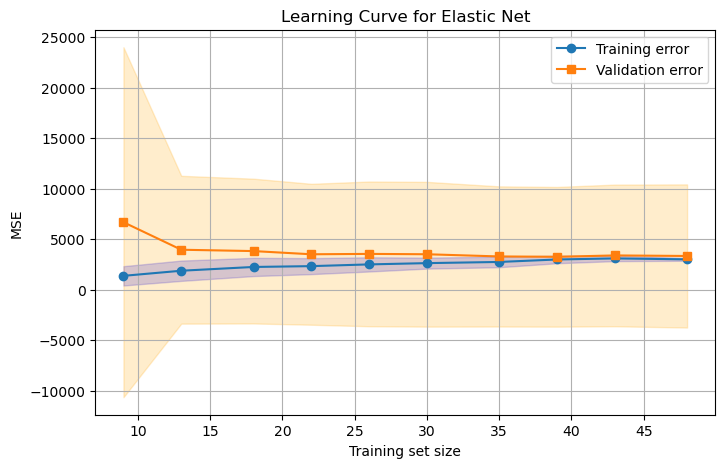

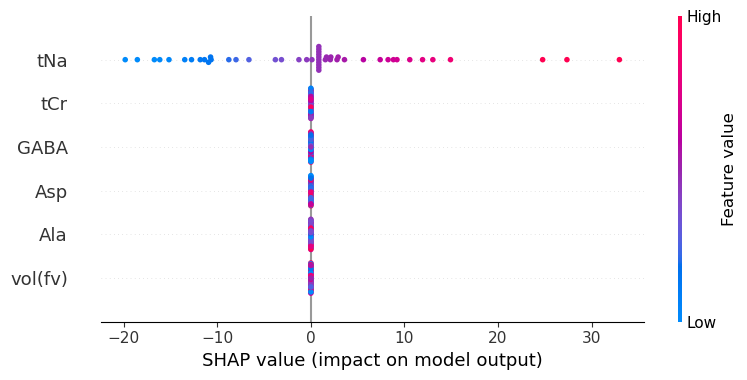

In [19]:
from sklearn.linear_model import ElasticNet

# Pipeline: Imputer + Scaler + PLS + Model

pipe = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=6, feature_names=feature_names)),
    ("elasticnet", ElasticNet(max_iter=50000))
])

# Hyperparameter grid
param_grid = {
    "elasticnet__alpha": np.logspace(-3, 3, 10),
    "elasticnet__l1_ratio": [0.1, 0.5, 0.7, 0.9, 1.0]  # 1.0 = Lasso, 0.0 = Ridge
}


grid = GridSearchCV(pipe, param_grid, cv=loo, scoring="neg_mean_squared_error")
grid.fit(X, y)
best_alpha = grid.best_params_["elasticnet__alpha"]
best_l1_ratio = grid.best_params_["elasticnet__l1_ratio"]
print("Best alpha:", best_alpha)
print("Best l1_ratio:", best_l1_ratio)


# Evaluate with LOO-CV and track selected features

pipe_best = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=6, feature_names=feature_names)),
    ("elasticnet", ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=50000))
])

y_pred = np.zeros_like(y, dtype=float)
selected_features_all = []

for train_idx, test_idx in loo.split(X):
    pipe_best.fit(X[train_idx], y[train_idx])
    y_pred[test_idx] = pipe_best.predict(X[test_idx])
    selected_features_all.extend(pipe_best.named_steps["pls_select"].get_feature_names())

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"LOO-CV ElasticNet+PLS: MSE={mse:.3f}, R²={r2:.3f}")

# see selected features to asure consistency in the selection
feature_counts = Counter(selected_features_all)
print("\nFeature selection stability aka each feature was chosen:")
for feat, count in feature_counts.most_common():
    print(f"{feat}: {count}/{len(y)} times")


#Plotting of the learning curve
plot_learning_curve(pipe_best, X, y, cv=loo, scoring="neg_mean_squared_error", title="Learning Curve for Elastic Net")

#Shap to visually explain the model
plot_shap_summary(pipe_best, X, y, feature_step="pls_select", model_step="elasticnet")

#### Decision Tree

Best Decision Tree params: {'tree__max_depth': None, 'tree__min_samples_leaf': 2, 'tree__min_samples_split': 10}
LOO-CV DecisionTree+PLS: MSE=4716.433, R²=-0.410

Feature selection stability aka each feature was chosen:
vol(fv): 49/49 times
GABA: 49/49 times
tNa: 49/49 times
Asp: 46/49 times
Ala: 33/49 times
tCr: 24/49 times
Lac: 20/49 times
perfthal: 18/49 times
tCo: 3/49 times
perfctx: 1/49 times
Myo: 1/49 times
Gsh: 1/49 times


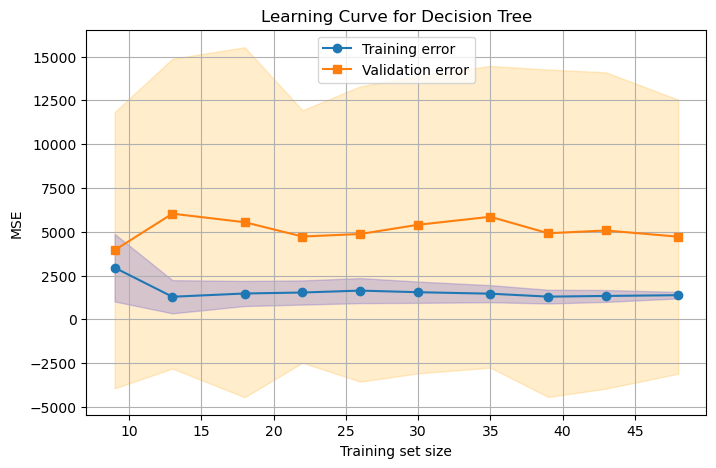

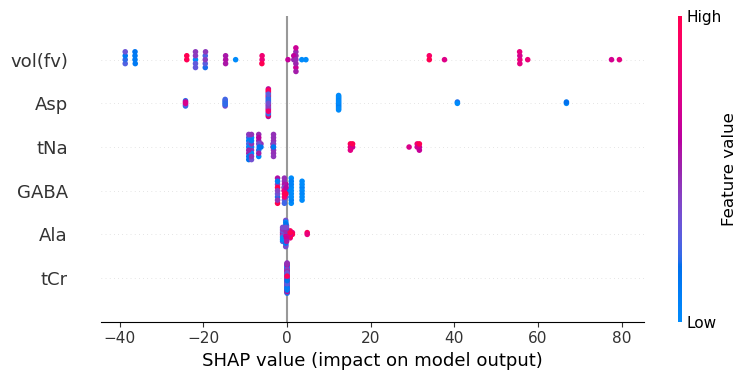

In [10]:
from sklearn.tree import DecisionTreeRegressor

#Pipeline = imputing + scaling + feature selection (PLS) + model
pipe = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=6, feature_names=feature_names)),
    ("tree", DecisionTreeRegressor(random_state=42))
])

# Hyperparameter grid for decision tree
param_grid = {
    "tree__max_depth": [2, 3, 4, 5, None],
    "tree__min_samples_split": [2, 5, 10],
    "tree__min_samples_leaf": [1, 2, 4]
}

grid = GridSearchCV(pipe, param_grid, cv=loo, scoring="neg_mean_squared_error")
grid.fit(X, y)
best_params = grid.best_params_
best_params_clean = {k.replace("tree__", ""): v for k, v in best_params.items()}
print("Best Decision Tree params:", best_params)

# Evaluation with loo-cv
pipe_best = Pipeline([
    ("imputer", KNNImputer(n_neighbors=3)),
    ("scaler", RobustScaler()),
    ("pls_select", PLSFeatureSelector(n_components=2, n_features=6, feature_names=feature_names)),
    ("tree", DecisionTreeRegressor(**best_params_clean, random_state=42))
])

y_pred = np.zeros_like(y, dtype=float)
selected_features_all = []

for train_idx, test_idx in loo.split(X):
    pipe_best.fit(X[train_idx], y[train_idx])
    y_pred[test_idx] = pipe_best.predict(X[test_idx])
    selected_features_all.extend(pipe_best.named_steps["pls_select"].get_feature_names())

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"LOO-CV DecisionTree+PLS: MSE={mse:.3f}, R²={r2:.3f}")

#Reporting on chosen features
feature_counts = Counter(selected_features_all)
print("\nFeature selection stability aka each feature was chosen:")
for feat, count in feature_counts.most_common():
    print(f"{feat}: {count}/{len(y)} times")

#Plotting of the learning curve
plot_learning_curve(pipe_best, X, y, cv=loo, scoring="neg_mean_squared_error", title="Learning Curve for Decision Tree")

#Shap to visually explain the model
plot_shap_summary(pipe_best, X, y, feature_step="pls_select", model_step="tree")